# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'device': 'cpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `n_jobs`, and `verbose` as the values for these are hardcoded to the notebook.**

In [19]:
MODEL_FILENAME = "RYZEN2" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

TB_HYPERPARAMS = None # None or like "{'tree_learner': 'data', 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}" # Set as None for truly defaults.
IB_HYPERPARAMS = None # None or like "{'tree_learner': 'data', 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}" # Set as None for truly defaults.

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/LGBM Tuning/RYZEN2_LGBM_TB.tune" # <== Empty string or Pointing a .tune file; Overrides the value set above. 
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/LGBM Tuning/RYZEN2_LGBM_IB.tune" # <== Empty string or Pointing a .tune file; Overrides the value set above. 

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Think of this as a seed generator which allows for a more consistent "randomization" which also applies on other areas of the study (i.e., dataset, tuning, and eval)

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [20]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt
from sklearn import tree

#GBDT Models
import lightgbm
# import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [21]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

    
start = end = 0
LOG_FILENAME = "LGBM_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'boosting_type': 'gbdt', 'cat_l2': 10, 'class_weight': 'balanced', 'data_sample_strategy': 'goss', 'device': 'gpu', 'enable_bundle': 'True', 'learning_rate': 0.1, 'max_depth': 500, 'n_estimators': 250, 'num_leaves': 32, 'objective': 'binary', 'tree_learner': 'voting'}

Parsed IB Hyperparams: {'boosting_type': 'gbdt', 'cat_l2': 15, 'class_weight': 'balanced', 'data_sample_strategy': 'goss', 'device': 'gpu', 'enable_bundle': 'True', 'learning_rate': 0.1, 'max_depth': 250, 'n_estimators': 250, 'num_leaves': 16, 'objective': 'binary', 'tree_learner': 'voting'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [22]:
#Setting filenames of files
TB_Train = "../Dataset/TB/LGBM_TB.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/LGBM_TB_Test.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/LGBM_IB.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/LGBM_IB_Test.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.3.2. Loading datasets to DataFrames

In [23]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72984, 101)
IB Train Size: (72984, 101)


### 1.3.3. Previewing datasets

In [24]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,286,110,172,240,117,240,117,240,117,...,260,141,65,86,99,71,215,240,117,240
1,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,260
2,1,208,286,76,110,240,117,208,187,208,...,260,141,65,260,225,35,225,35,286,240
3,1,208,286,76,110,240,117,208,187,208,...,286,82,240,286,117,262,286,240,286,117
4,1,240,117,240,117,240,117,240,117,240,...,15,240,117,240,117,240,117,172,60,225


In [25]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,286,110,172,240,117,106,171,260,141,...,307,307,307,307,307,307,307,307,307,307
1,1,82,240,117,172,16,11,274,158,215,...,307,307,307,307,307,307,307,307,307,307
2,1,208,286,76,110,240,117,187,198,228,...,307,307,307,307,307,307,307,307,307,307
3,1,208,286,76,110,240,117,187,198,228,...,307,307,307,307,307,307,307,307,307,307
4,1,240,117,228,215,274,158,172,198,208,...,307,307,307,307,307,307,307,307,307,307


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [26]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [27]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(i)
    return indexes

def setup_model(HYPERPARAMS):
    global TUNED_TRAINING
    if HYPERPARAMS == None:
        return lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=0, verbose=-1)
    return lightgbm.LGBMClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, n_jobs=0, verbose=-1)

## 2.2. Training on Time-Based Behaviors

### 2.2.1. Training the Model

In [28]:
#Training Model
start_time()
tb_lgbm = setup_model(TB_HYPERPARAMS)
tb_lgbm.fit(X_tb_training, y_tb_training, eval_set=[(X_tb_validate, y_tb_validate), (X_tb_training, y_tb_training)], eval_metric=['binary_logloss', 'average_precision', 'auc'], categorical_feature=get_indexes())
end_time("LGBM_TB")

#Saving Model as file
dump(tb_lgbm, "Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB.model")

['Outputs/LGBM/TUNED_RYZEN2_LGBM_TB.model']

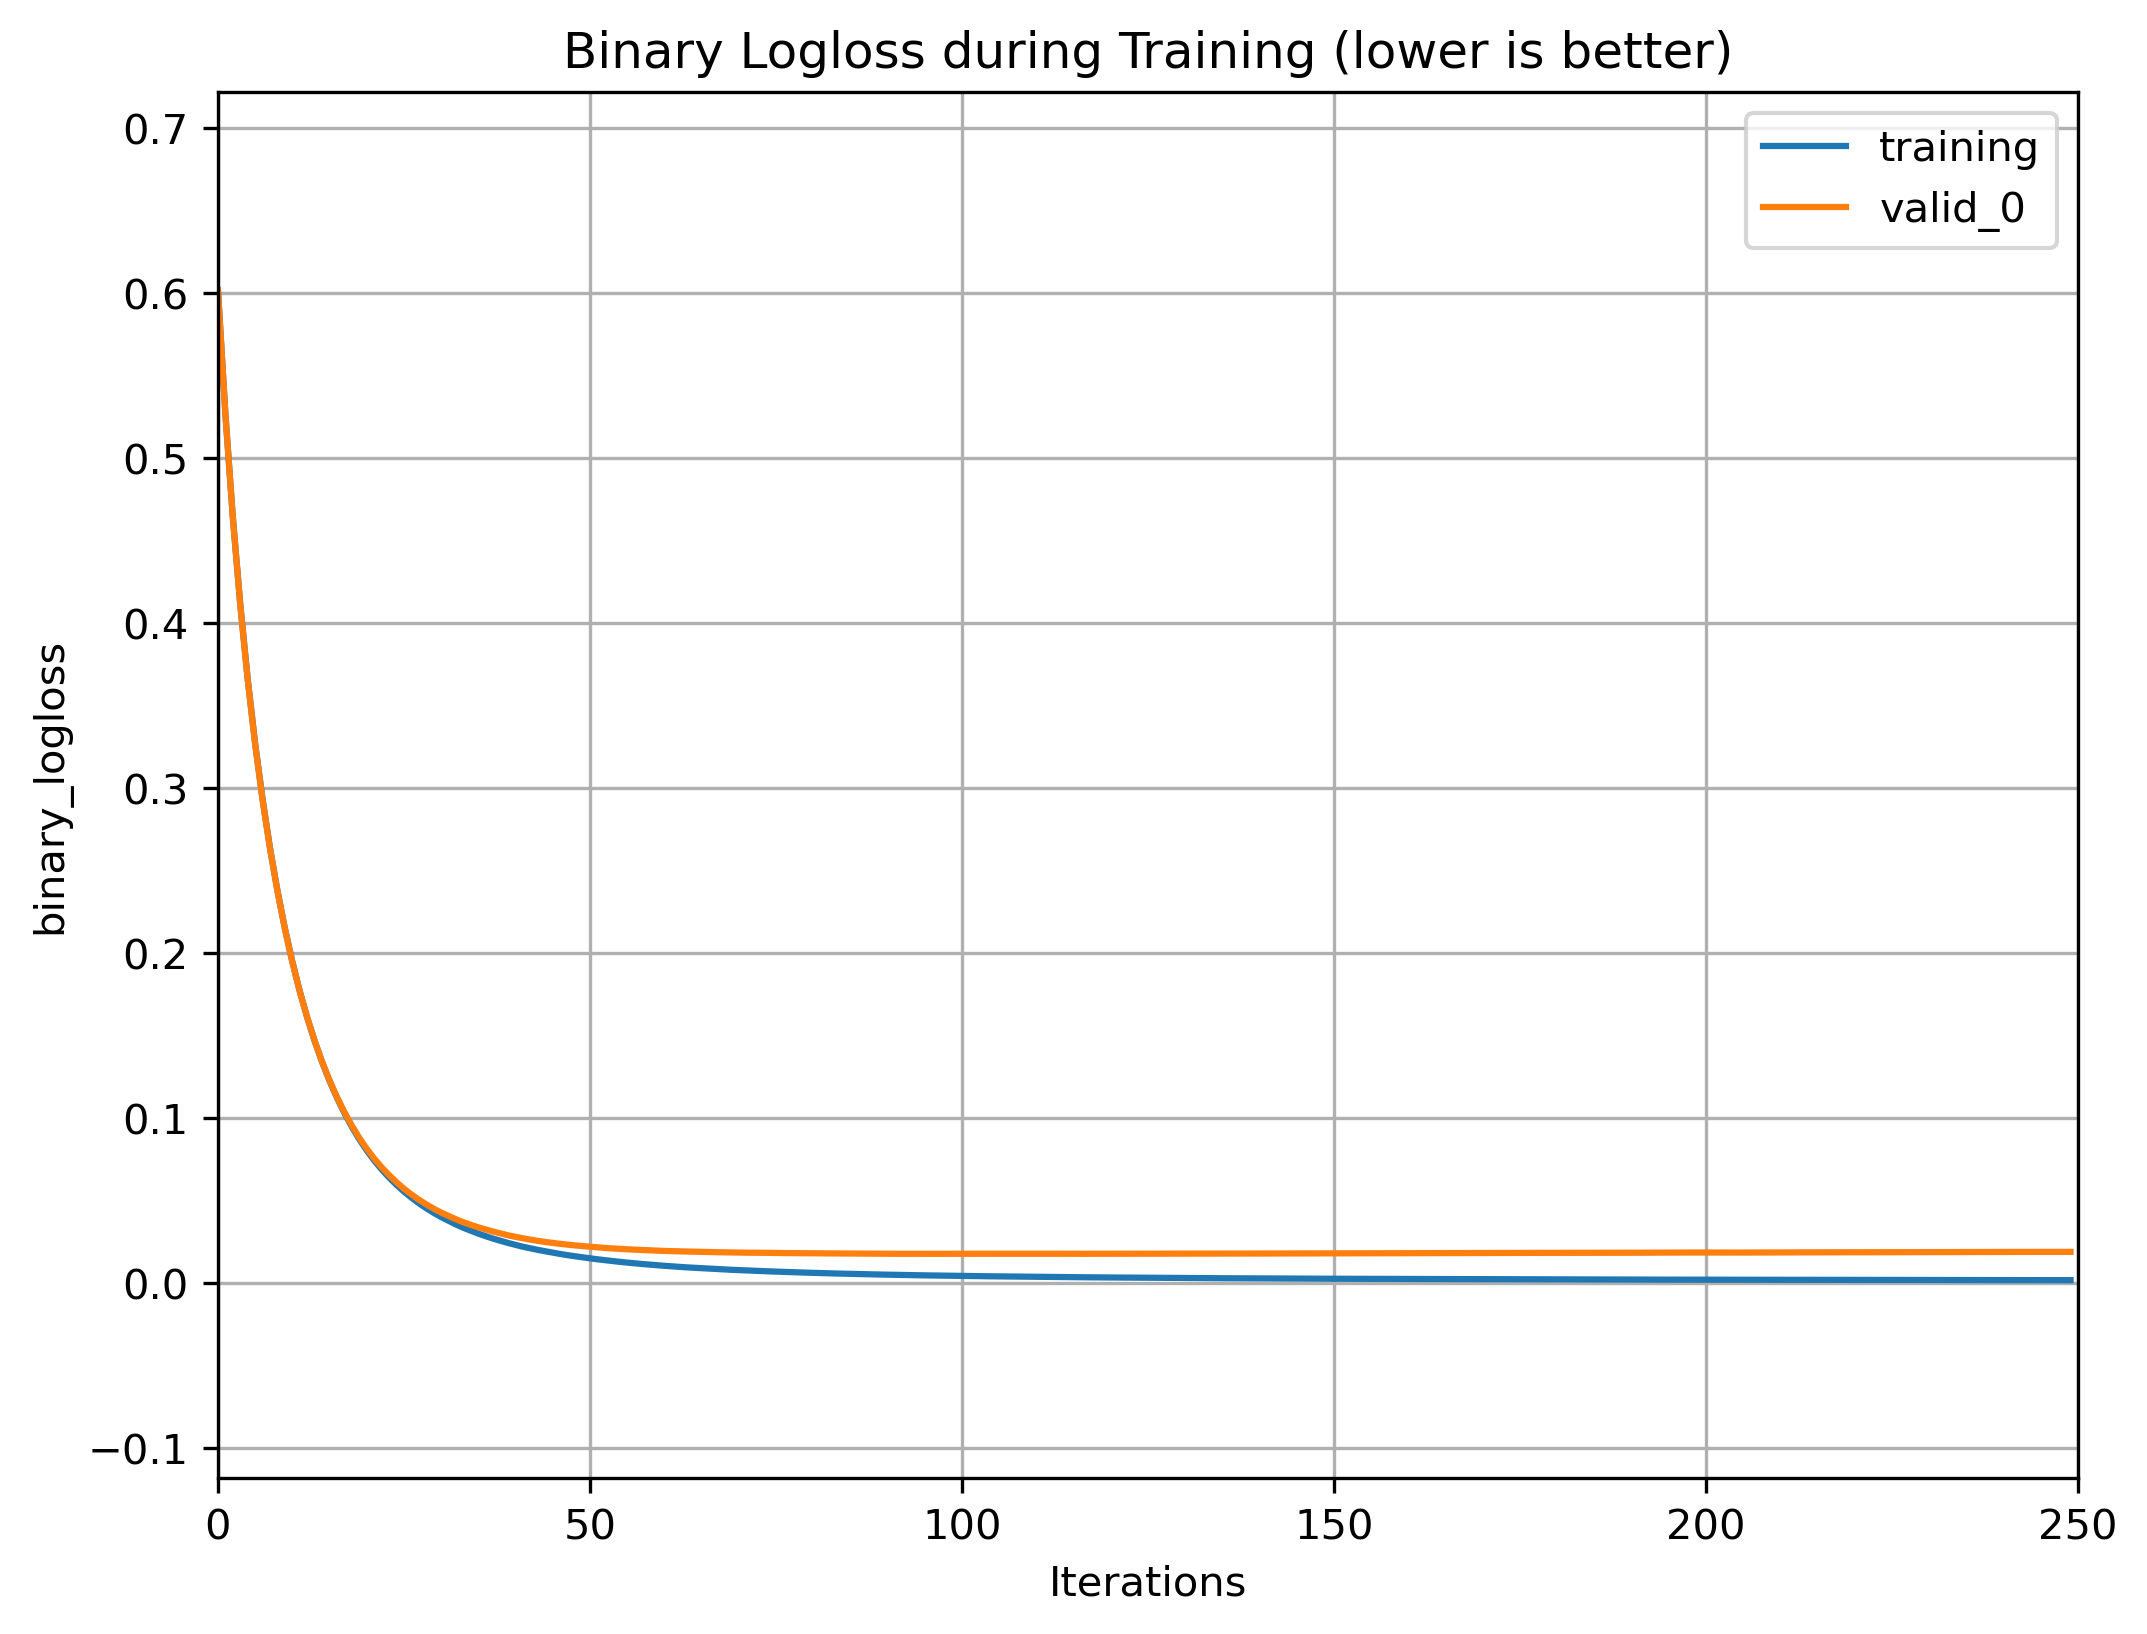

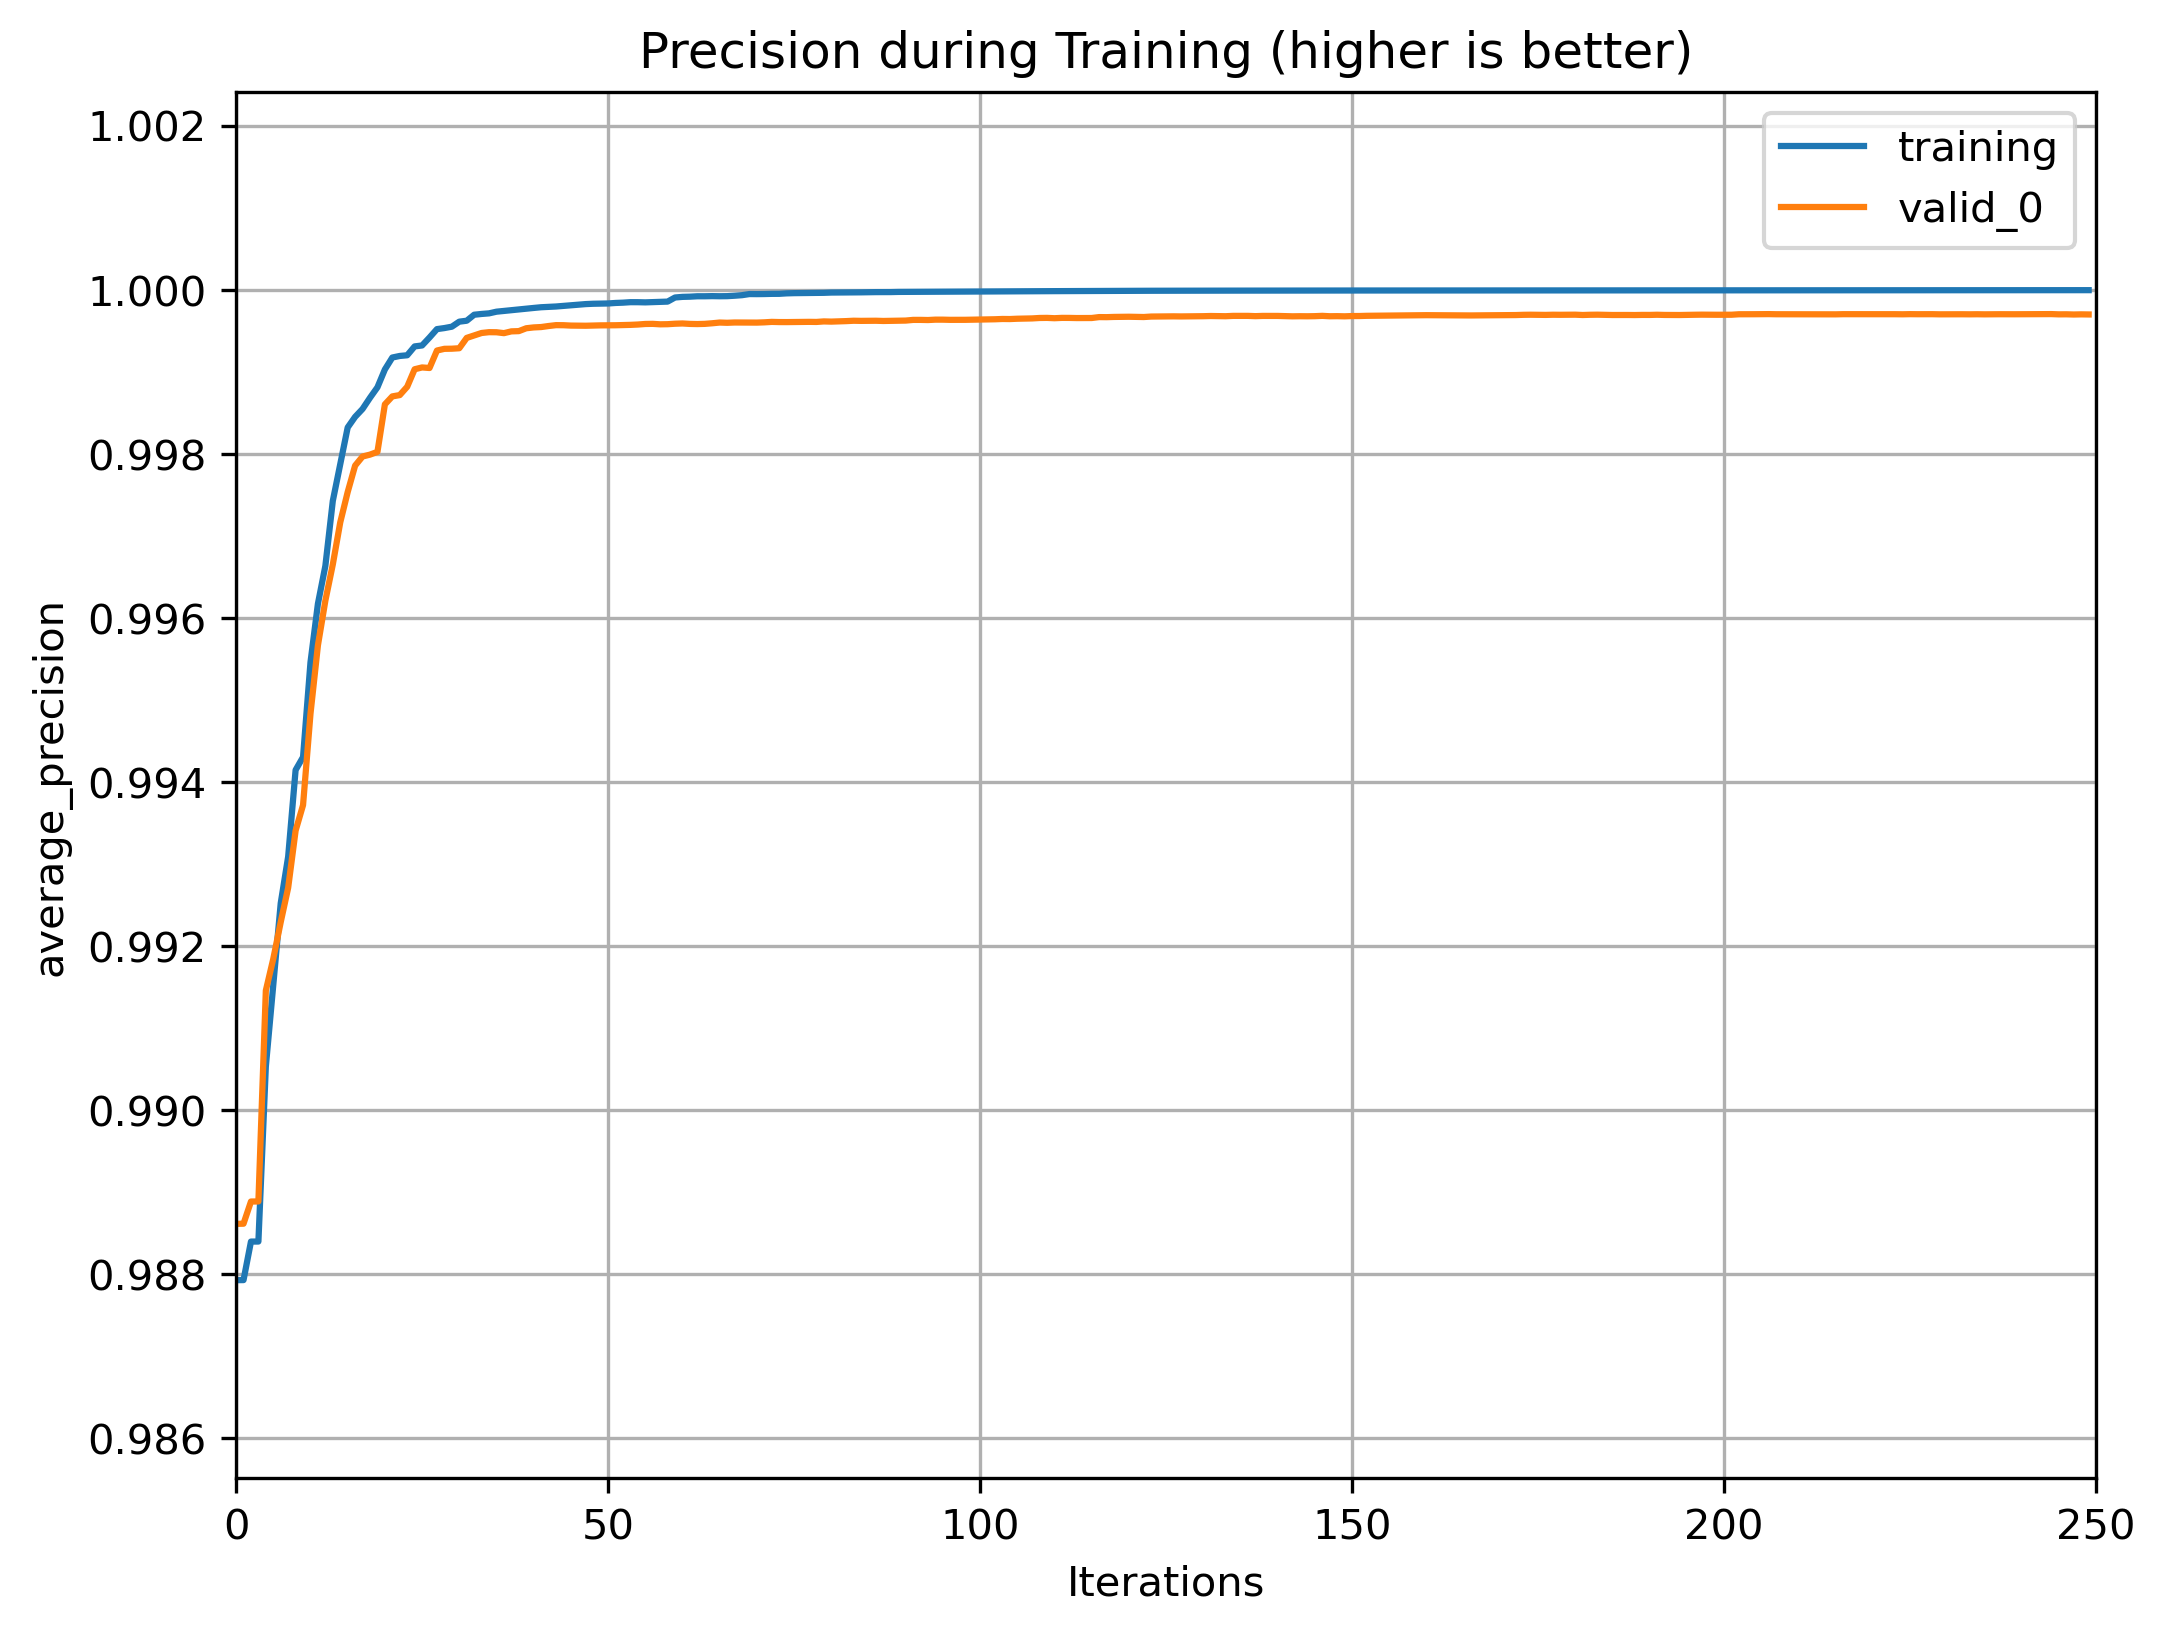

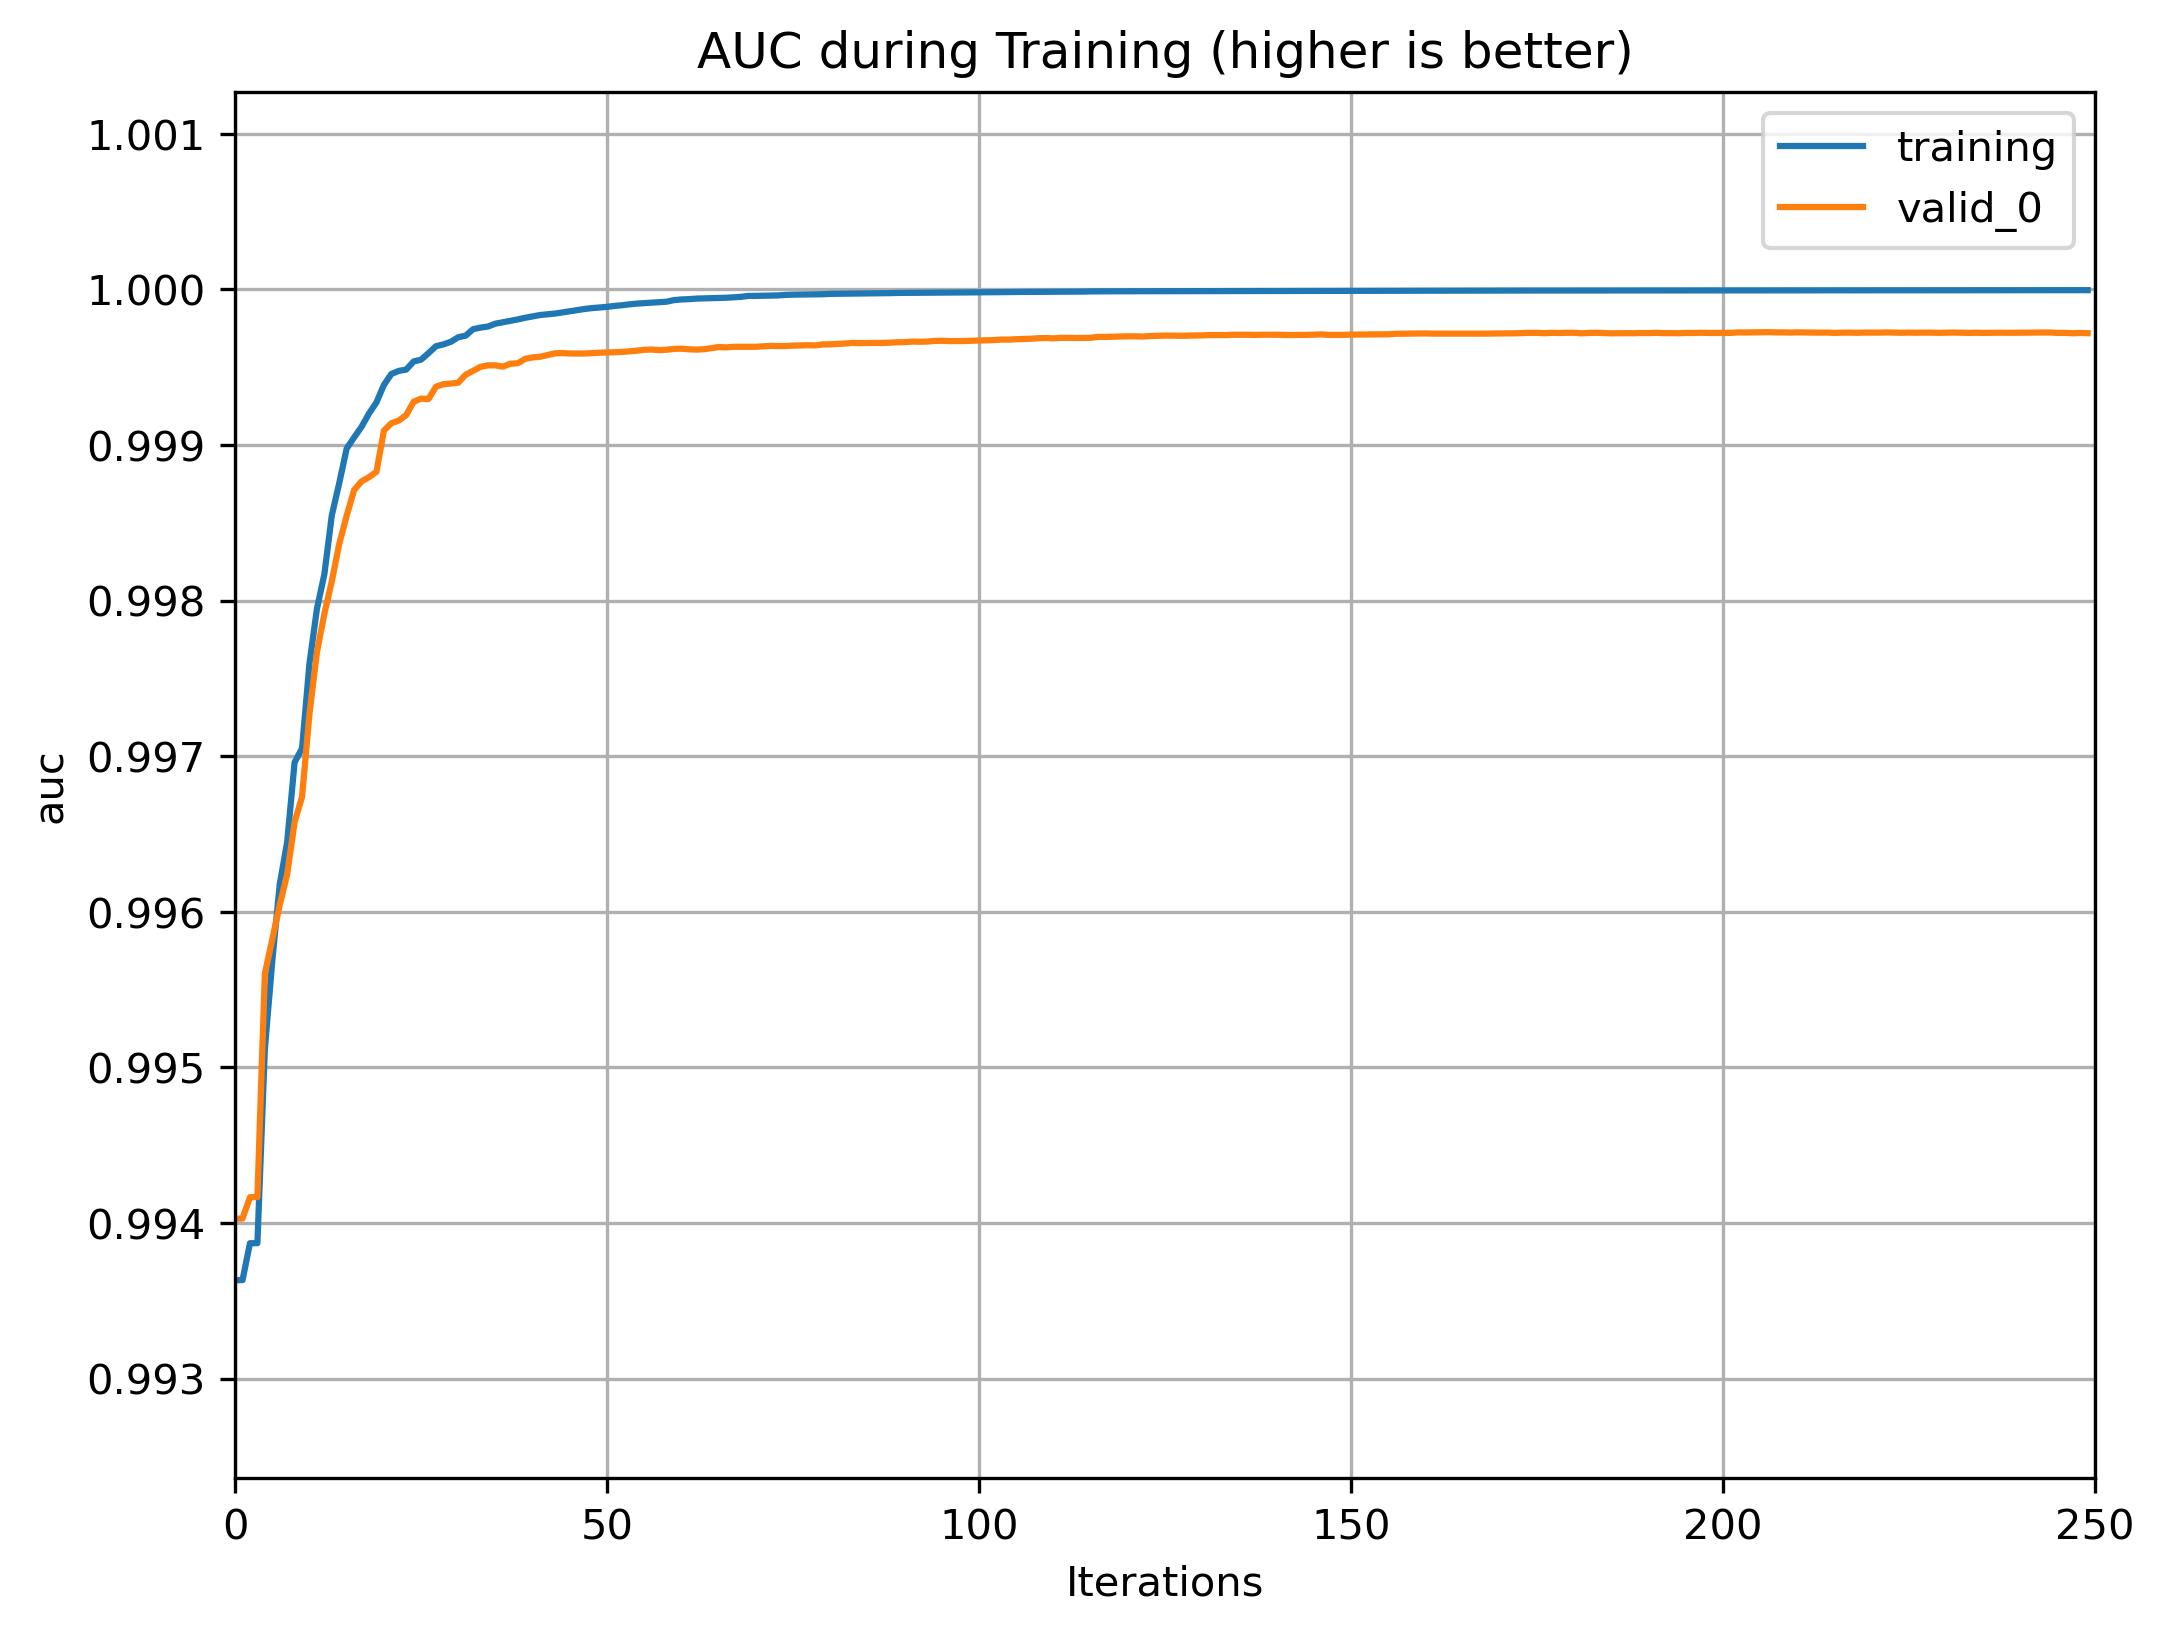

In [29]:
lightgbm.plot_metric(tb_lgbm, metric='binary_logloss', title='Binary Logloss during Training (lower is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_binary_logloss.png")
lightgbm.plot_metric(tb_lgbm, metric='average_precision', title='Precision during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_average_precision.png")
lightgbm.plot_metric(tb_lgbm, metric='auc', title='AUC during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_auc.png")

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

LBGM_TB
              precision    recall  f1-score   support

           0     0.9985    0.9906    0.9945     10905
           1     0.9907    0.9985    0.9946     10991

    accuracy                         0.9946     21896
   macro avg     0.9946    0.9945    0.9946     21896
weighted avg     0.9946    0.9946    0.9946     21896



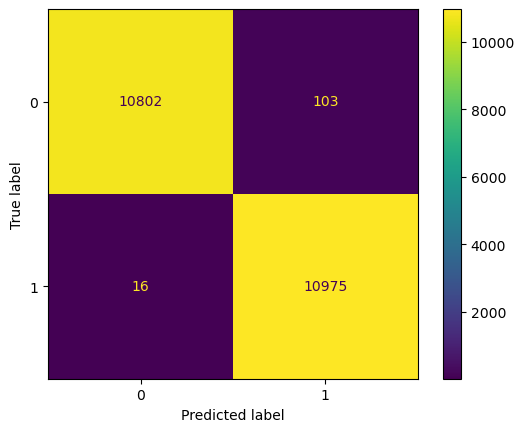

In [30]:
y_pred = tb_lgbm.predict(X_tb_validate)
print("LBGM_TB")
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [31]:
# One of the many layers of LGBM (1st tree)
# lightgbm.plot_tree(tb_lgbm, figsize=(10,10), dpi=600, show_info='data_percentage', precision=2, orientation='vertical')
# plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_tree.png")

## 2.3. Training on Instance-Based Behaviors

### 2.3.1. Training the Model

In [32]:
#Training Model
start_time()
ib_lgbm = setup_model(IB_HYPERPARAMS)
ib_lgbm.fit(X_ib_training, y_ib_training, eval_set=[(X_ib_validate, y_ib_validate), (X_ib_training, y_ib_training)], eval_metric=['binary_logloss', 'average_precision', 'auc'], categorical_feature=get_indexes())
end_time("LGBM_IB")

#Saving Model as file
dump(ib_lgbm, "Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB.model")

['Outputs/LGBM/TUNED_RYZEN2_LGBM_IB.model']

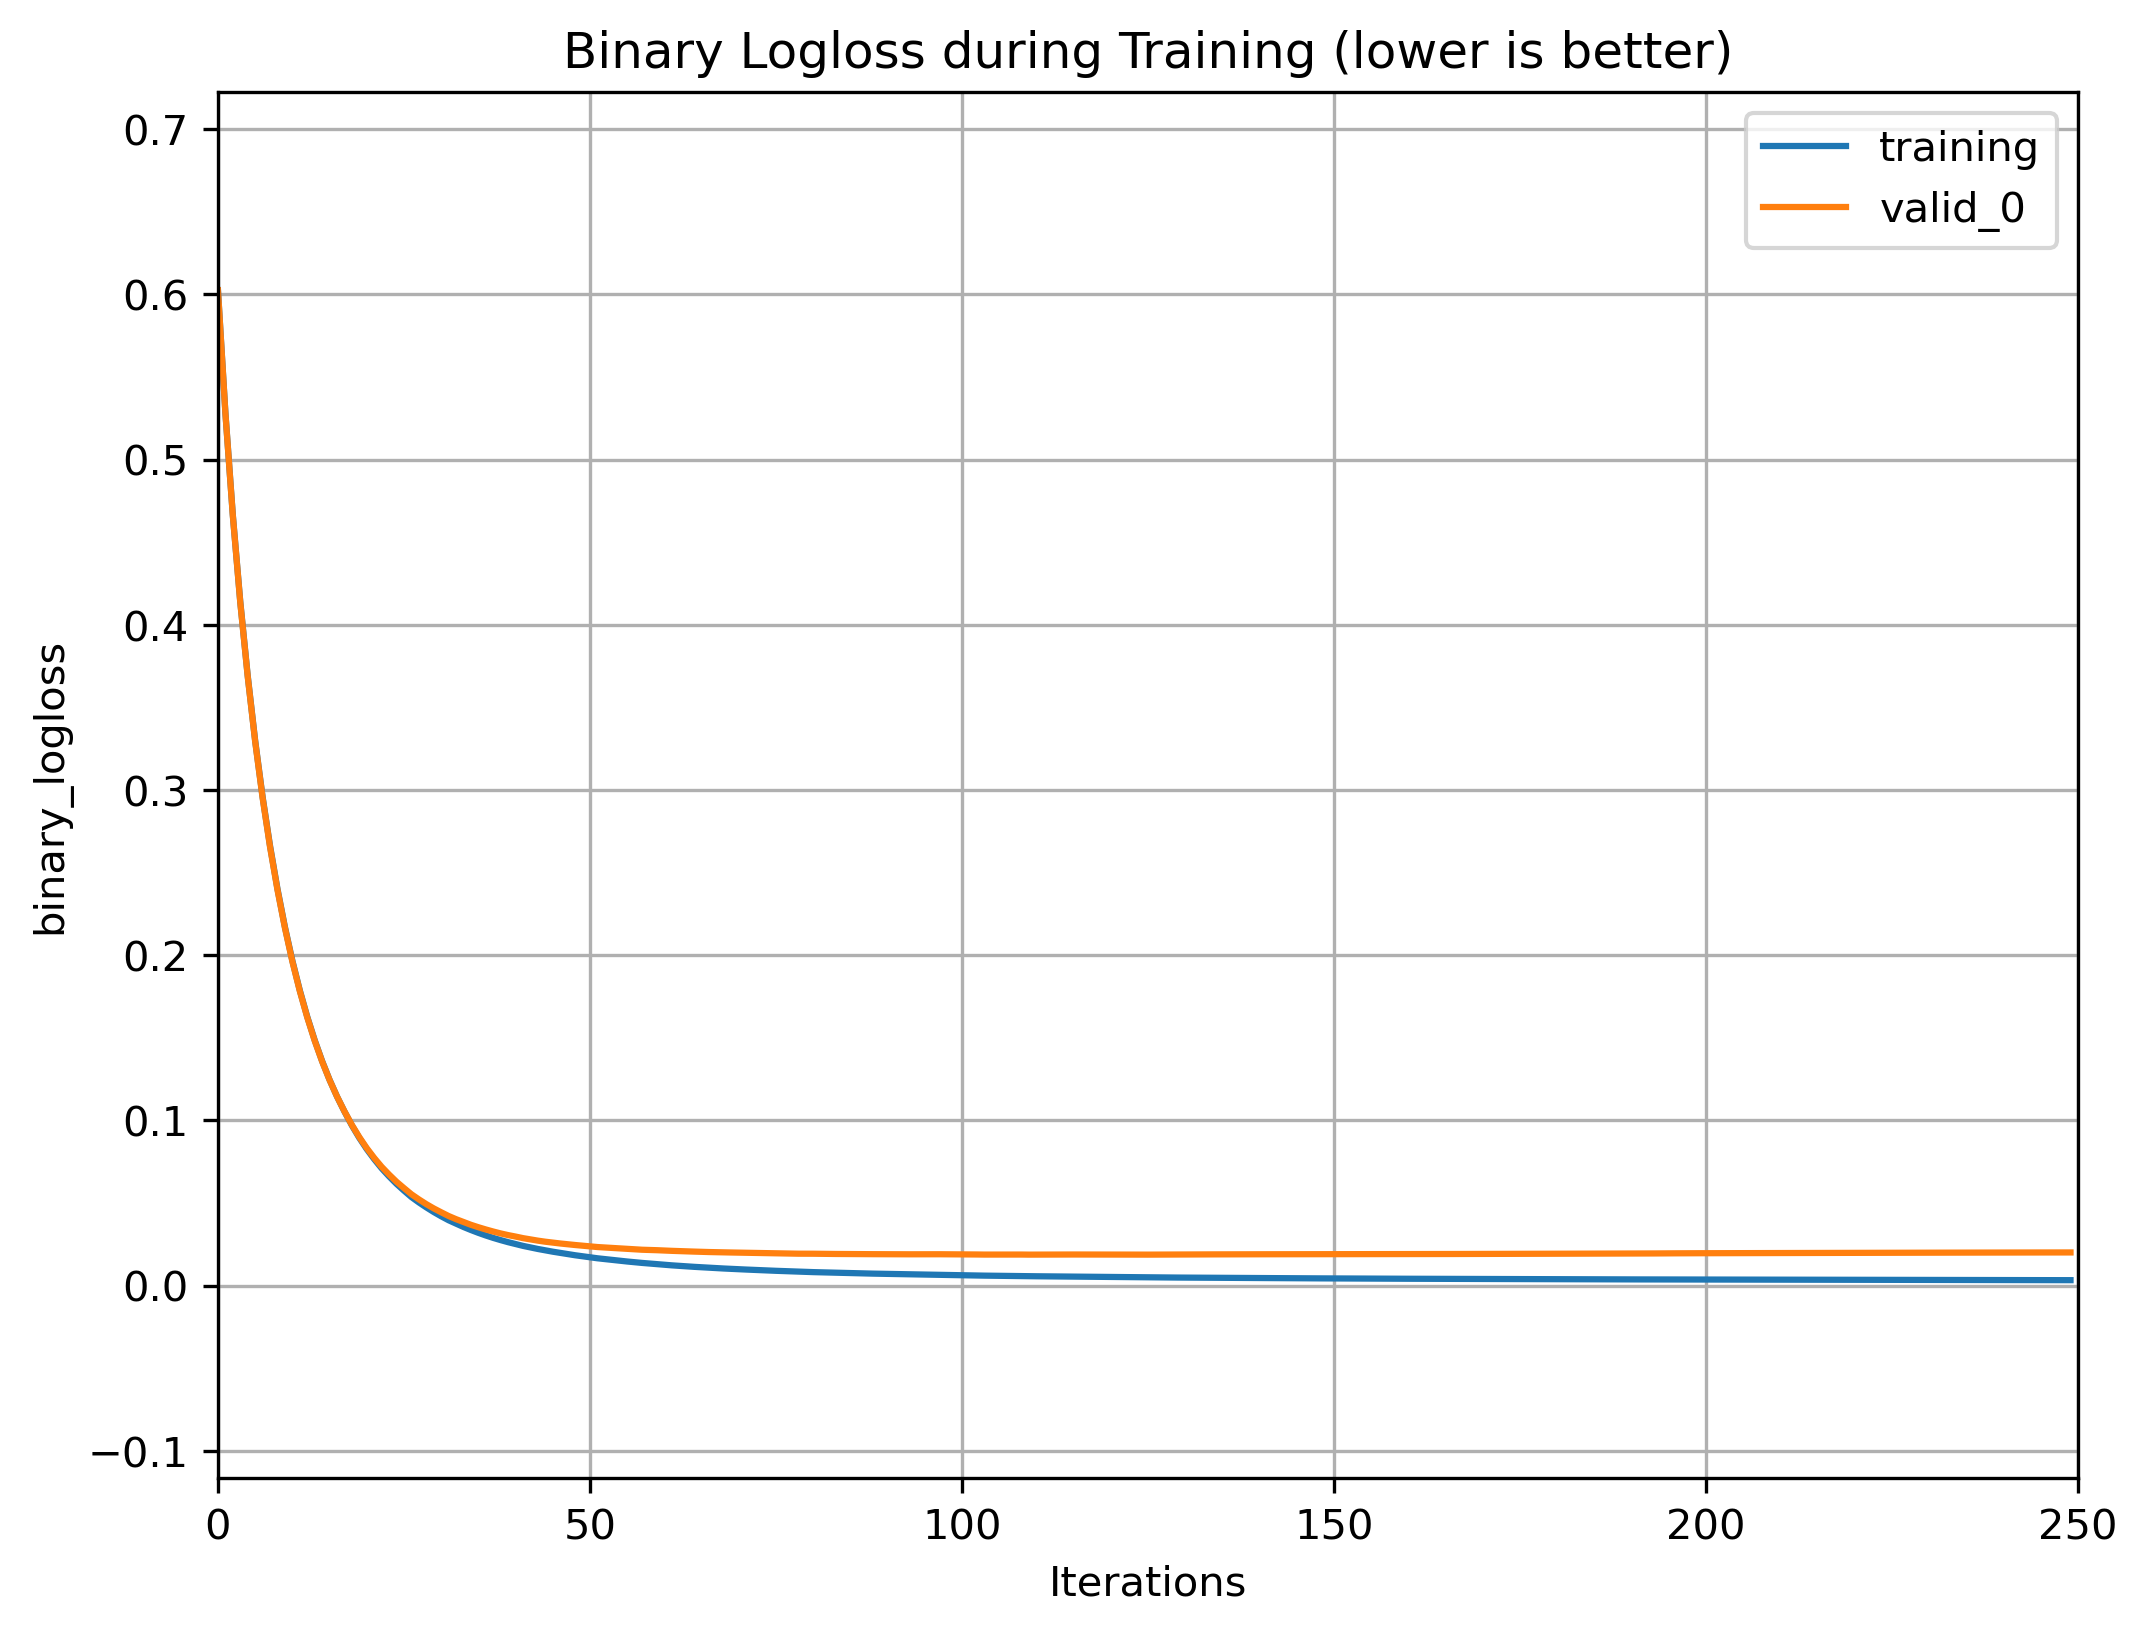

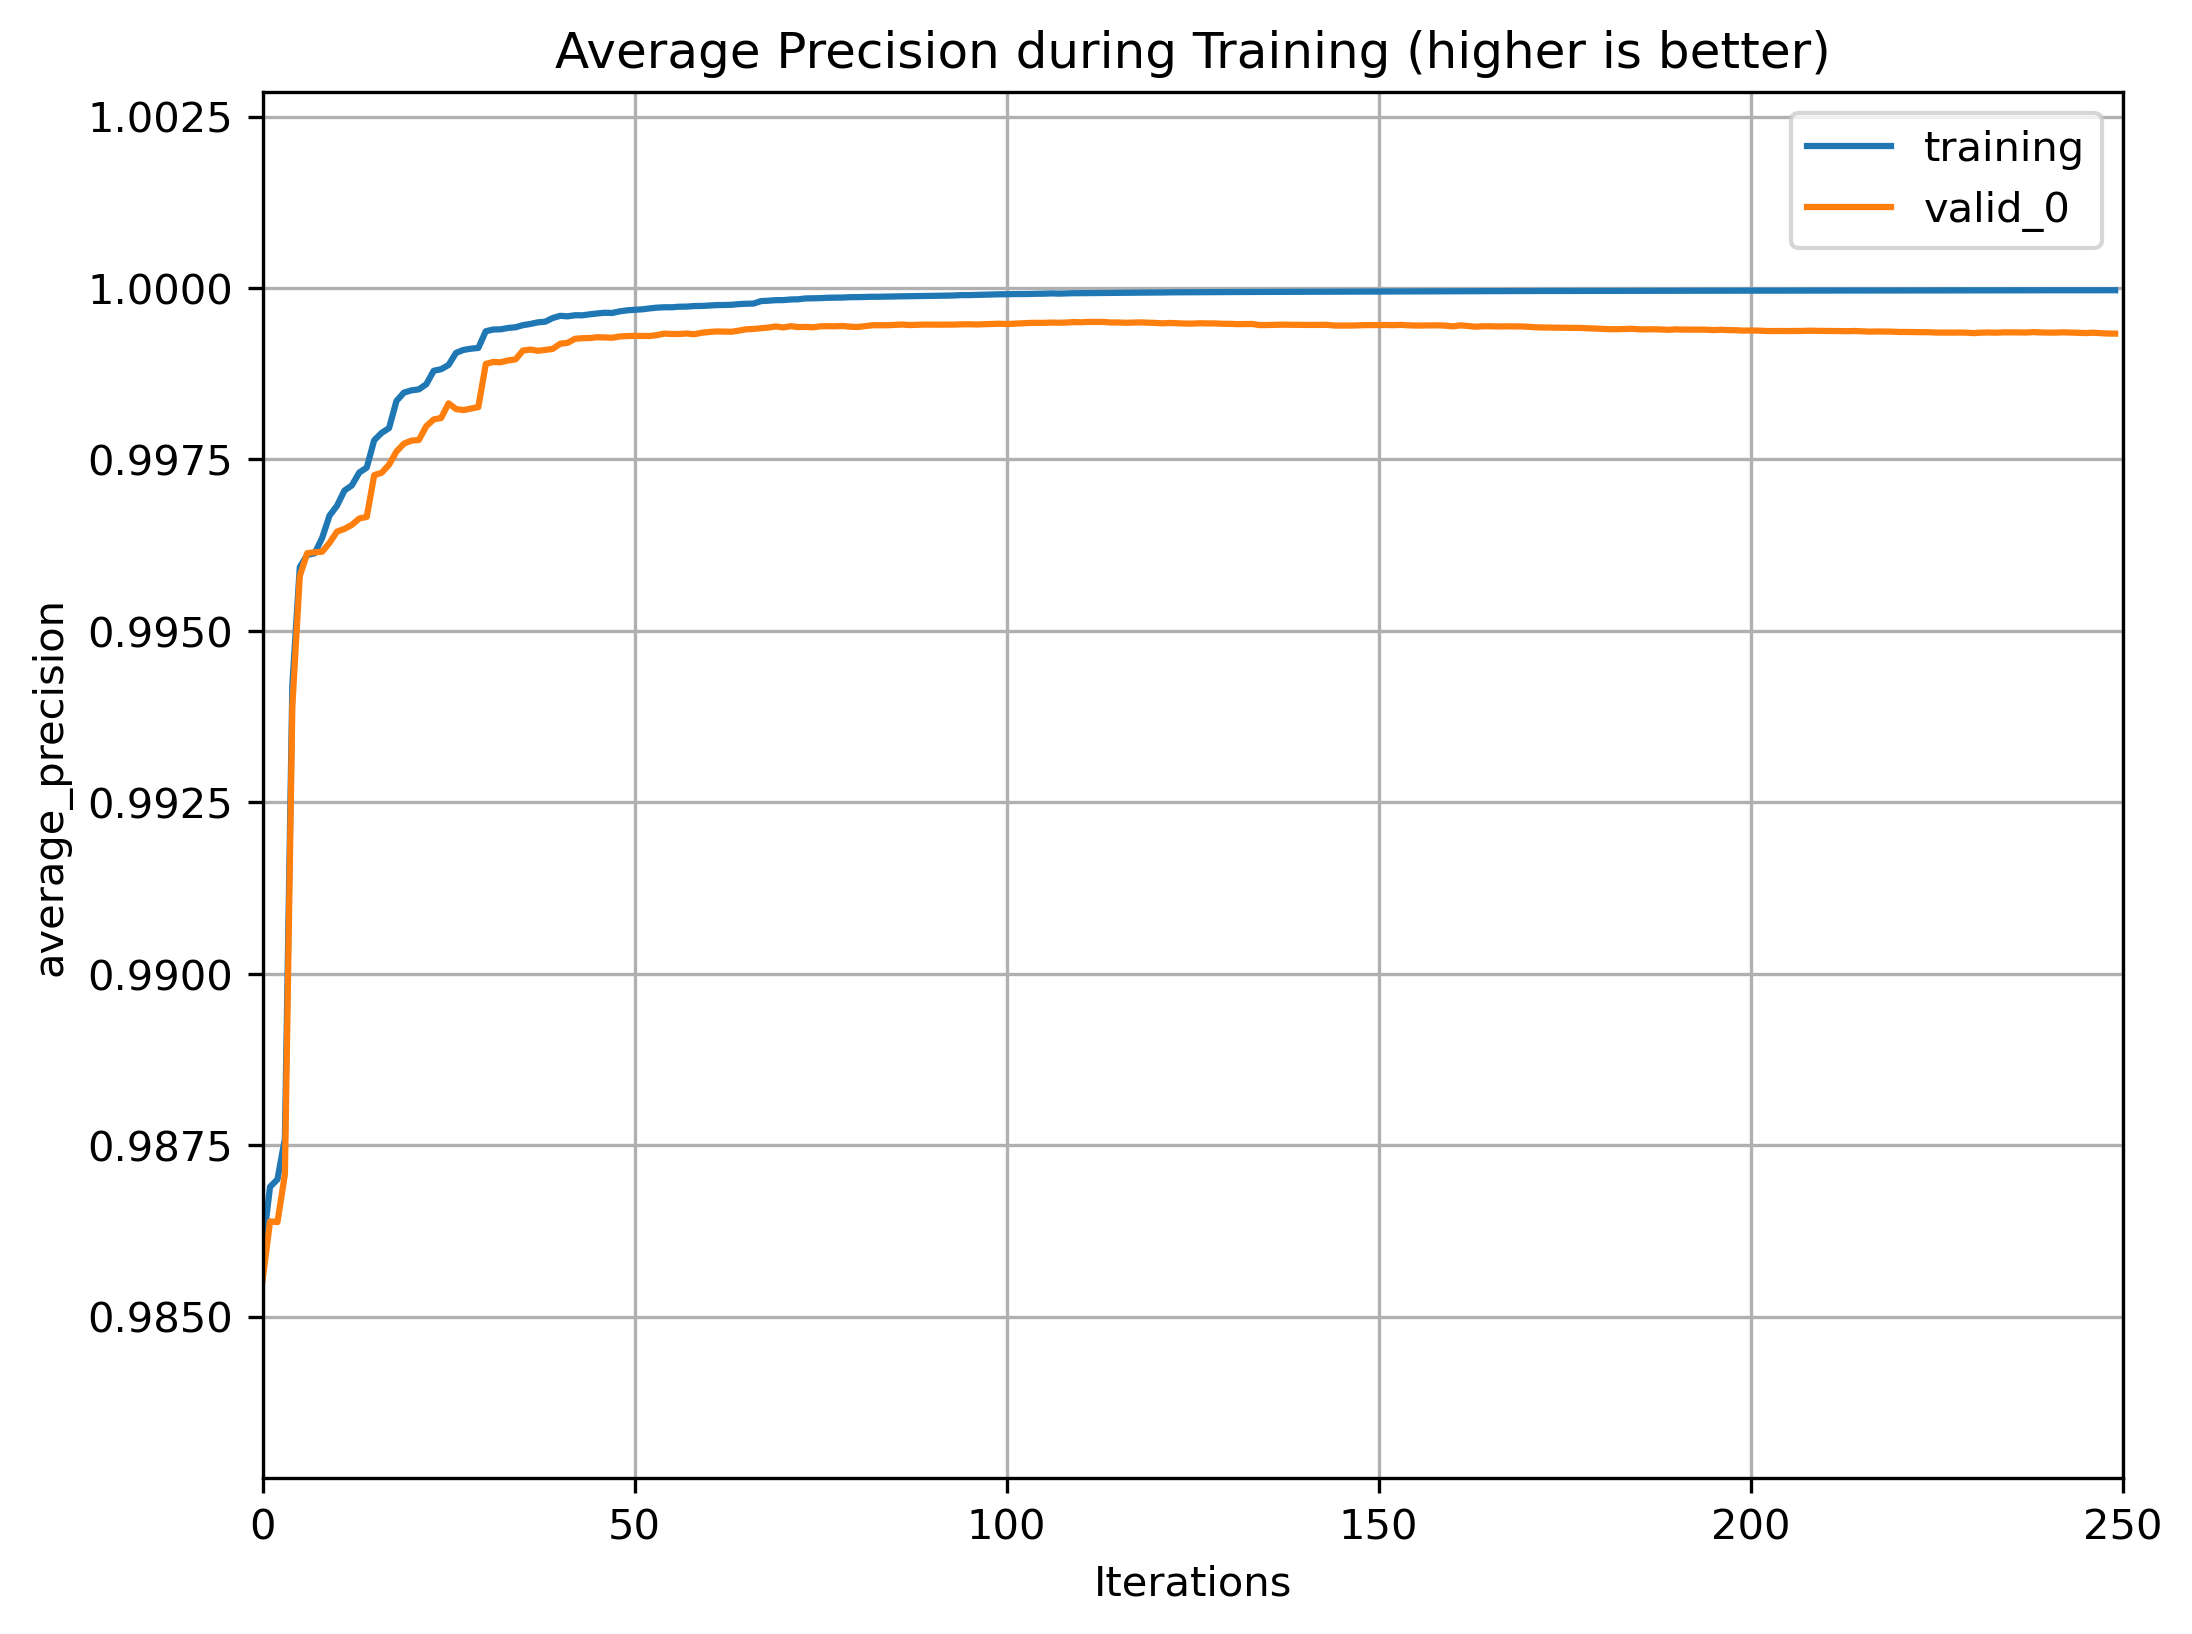

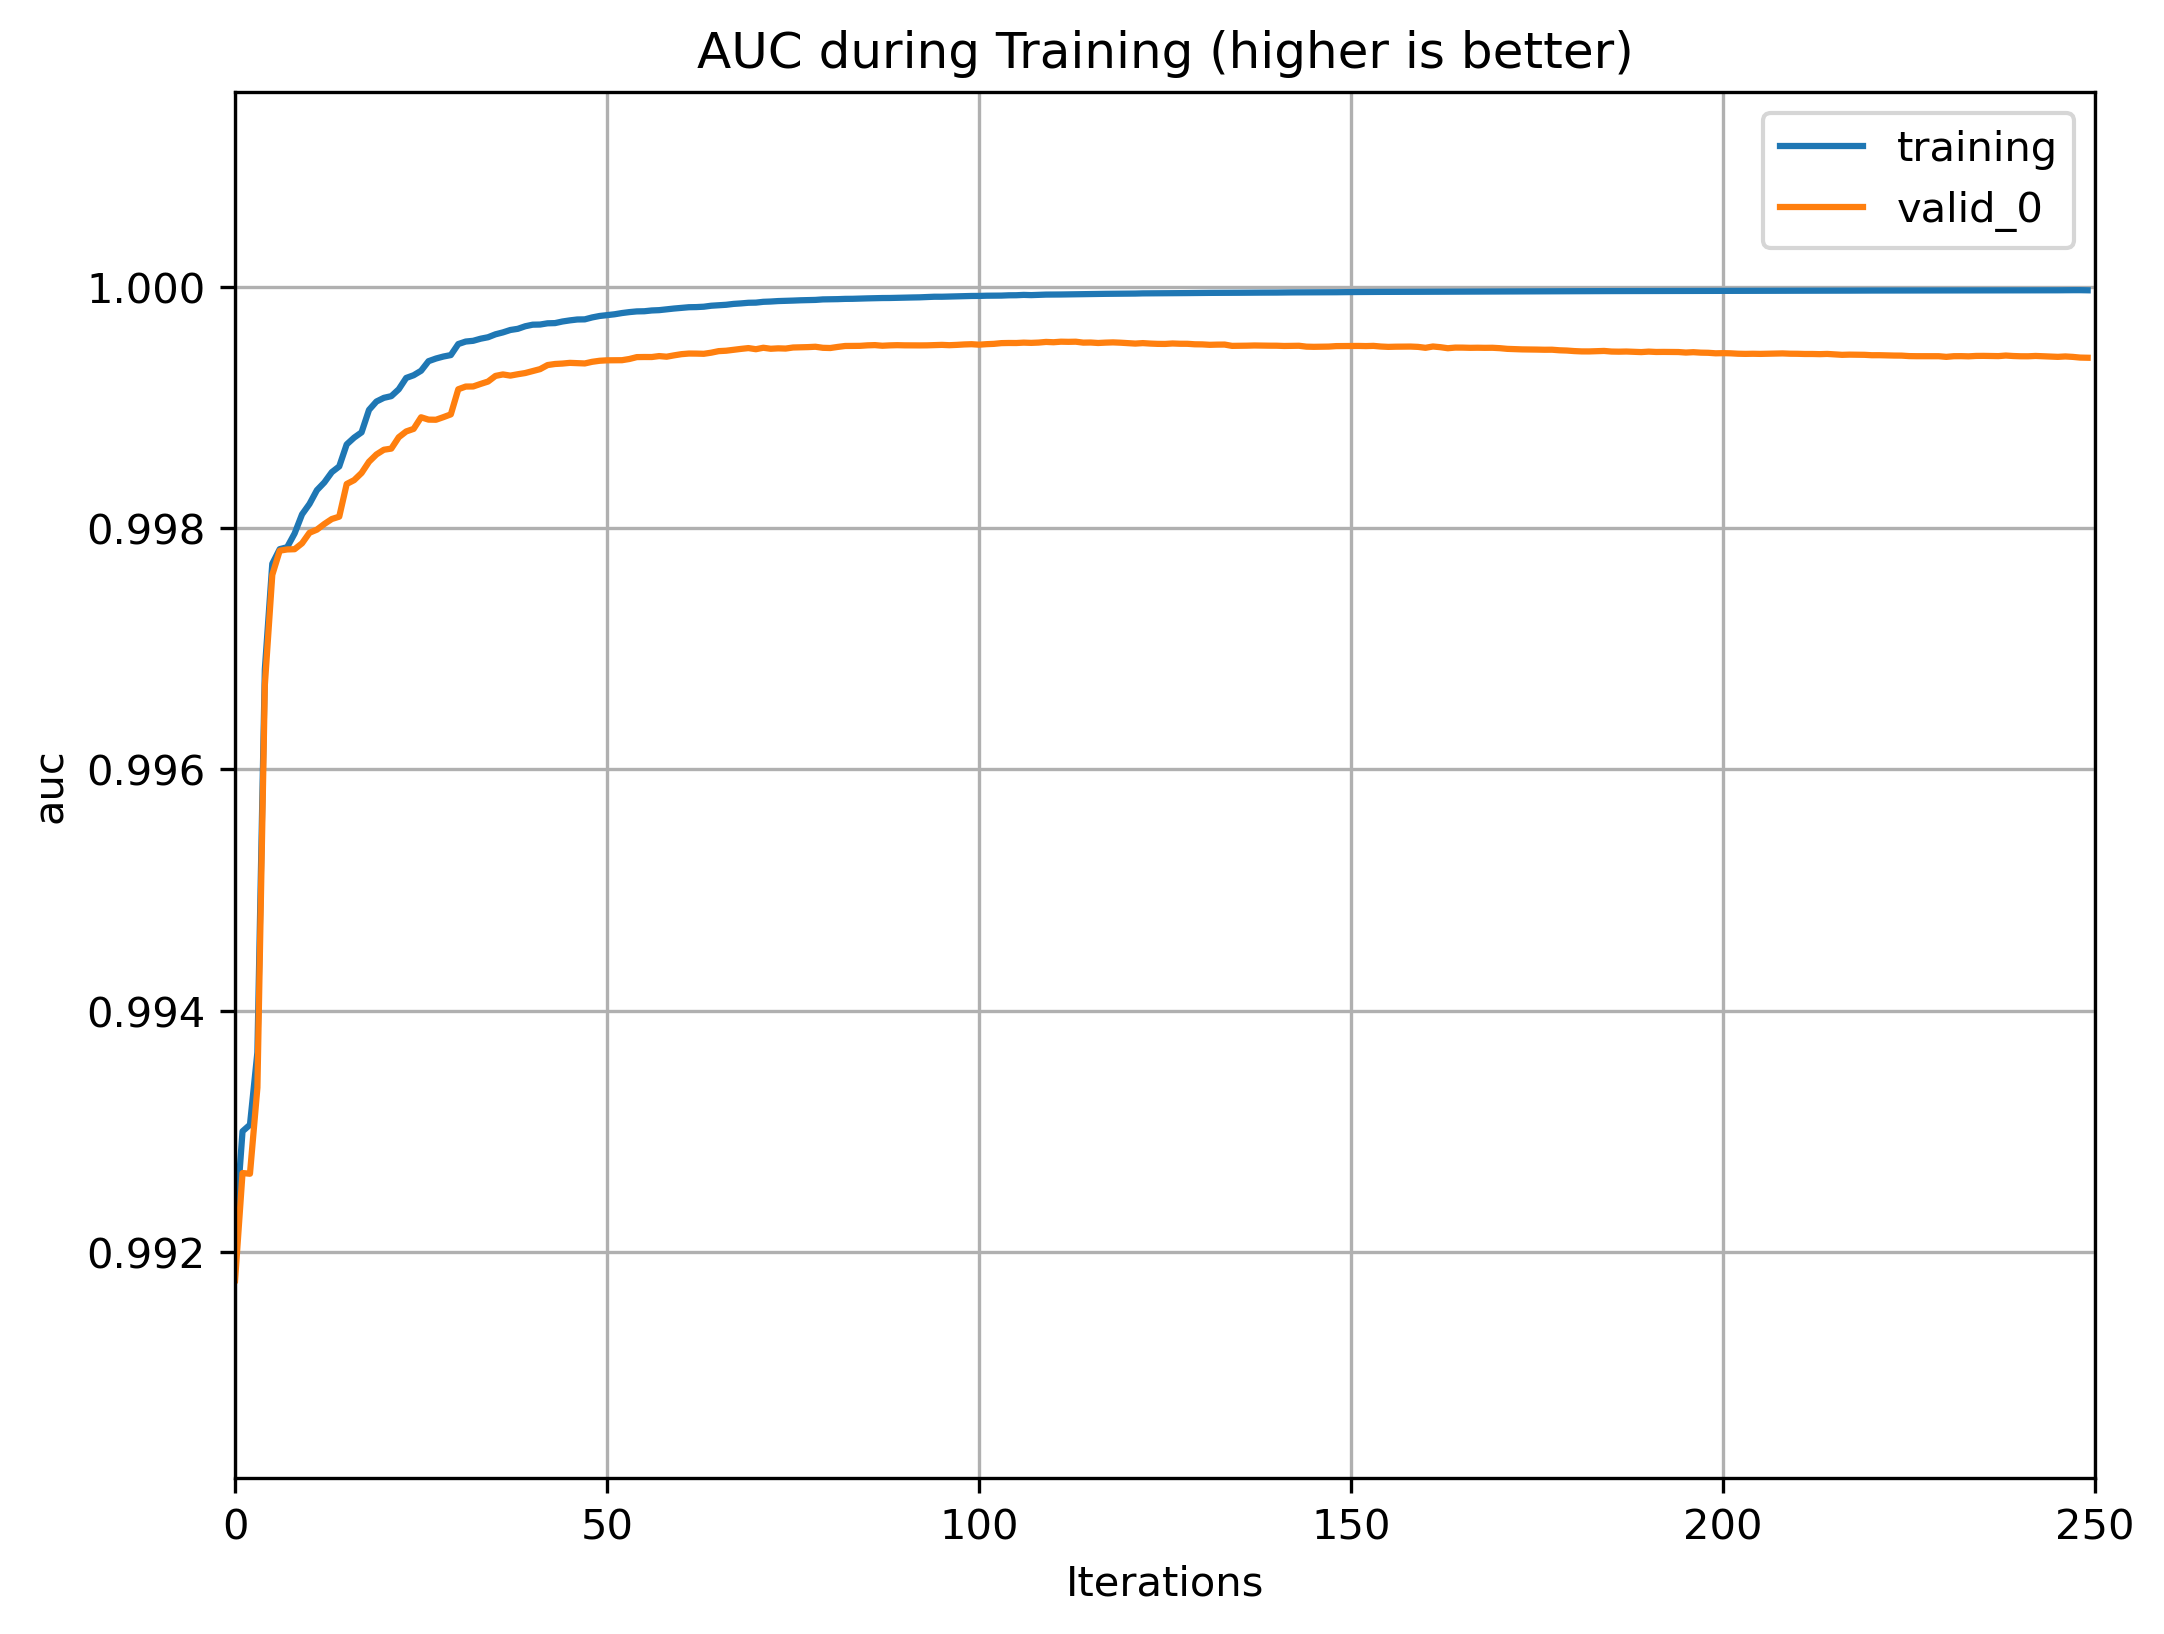

In [33]:
lightgbm.plot_metric(ib_lgbm, metric='binary_logloss', title='Binary Logloss during Training (lower is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_binary_logloss.png")
lightgbm.plot_metric(ib_lgbm, metric='average_precision', title='Average Precision during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_average_precision.png")
lightgbm.plot_metric(ib_lgbm, metric='auc', title='AUC during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_auc.png")

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

LBGM_IB
              precision    recall  f1-score   support

           0     0.9985    0.9912    0.9948     10905
           1     0.9913    0.9985    0.9949     10991

    accuracy                         0.9949     21896
   macro avg     0.9949    0.9949    0.9949     21896
weighted avg     0.9949    0.9949    0.9949     21896



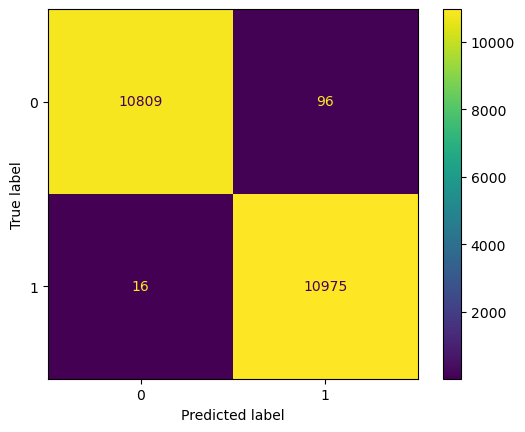

In [34]:
y_pred = ib_lgbm.predict(X_ib_validate)
print("LBGM_IB")
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [35]:
# One of the many layers of LGBM (1st tree)
# lightgbm.plot_tree(ib_lgbm, figsize=(10,10), dpi=600, show_info='data_percentage', precision=2, orientation='vertical')
# plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_tree.png")

In [36]:
logging("\n")